In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

print(torch.cuda.is_available())


True


In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

# Download the MNIST datasets
folder = "data"
trainset = datasets.MNIST(folder, train=True, download=True)
testset = datasets.MNIST(folder, train=False, download=True)

Total number of training samples 60000
Total number of testing samples 10000
5
Max pixel value 1.0, min pixel value 0.0


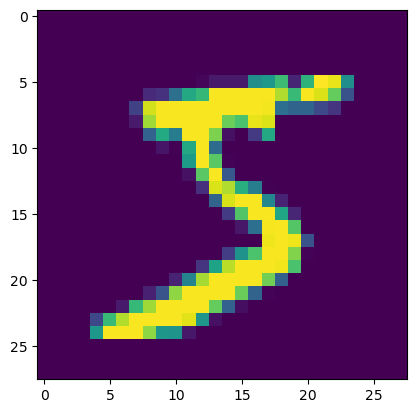

In [3]:
import matplotlib.pyplot as plt
from torchvision import transforms

to_tensor = transforms.ToTensor()

print(f"Total number of training samples {len(trainset)}")
print(f"Total number of testing samples {len(testset)}")
img, label = trainset[0]
plt.imshow(img)
print(label)
print(f"Max pixel value {to_tensor(img).max()}, min pixel value {to_tensor(img).min()}")

In [4]:
# preprocess the MNIST dataset by converting to tensor and normalizing the pixel values
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(datasets.MNIST(folder, train=True, download=False, transform=to_tensor), 
                          batch_size=batch_size,
                          drop_last=True)
test_loader = DataLoader(datasets.MNIST(folder, train=False, download=False, transform=to_tensor),
                         batch_size=batch_size,
                         drop_last=True)

In [12]:
import numpy as np

class Encoder(nn.Module):
    # Basic implementation as MLP
    def __init__(self, ninputs: int, nhidden: int, nlatent: int):
        super().__init__()
        self.ninputs = ninputs
        self.nhidden = nhidden
        nhidden2 = nhidden//2
        self.f_z = nn.Sequential(nn.Linear(ninputs, nhidden),
                                 nn.ReLU(),
                                 nn.Linear(nhidden, nhidden2),
                                 nn.ReLU())
        self.f_mu = nn.Linear(nhidden2, nlatent)
        self.f_sigma = nn.Linear(nhidden2, nlatent)
        self.f_L = nn.Linear(nhidden2, nlatent * nlatent)
        
    def forward(self, x):
        z_         = self.f_z(x)
        mu         = self.f_mu(z_)
        log_sigma  = self.f_sigma(z_)
        L_         = self.f_L(z_)
        return mu, log_sigma, L_

class Decoder(nn.Module):
    def __init__(self, ninputs: int, nhidden: int, nlatent: int):
        super().__init__()
        self.ninputs = ninputs
        self.nhidden = nhidden
        nhidden2 = nhidden//2
        self.f = nn.Sequential(nn.Linear(nlatent, nhidden2),
                               nn.ReLU(),
                               nn.Linear(nhidden2, nhidden),
                               nn.ReLU(),
                               nn.Linear(nhidden, ninputs),
                               nn.Sigmoid())
        
    def forward(self, z):
        p = self.f(z)
        return p

class VAE(nn.Module):
    def __init__(self, ninputs: int, nhidden: int, nlatent: int, nbatch: int, device):
        super().__init__()
        self.nbatch = nbatch
        self.nlatent = nlatent
        self.device = device
        self.encoder = Encoder(ninputs, nhidden, nlatent)
        self.decoder = Decoder(ninputs, nhidden, nlatent)
        
    def loss(self, x):
        mu, log_sigma, L_ = self.encoder(x)
        L          = torch.tril(L_.view((-1, self.nlatent, self.nlatent)), -1) + torch.diag_embed(torch.exp(log_sigma))
        L          = torch.diag_embed(torch.exp(log_sigma))
        eps        = torch.normal(torch.zeros((self.nbatch, self.nlatent, 1)), torch.ones((self.nbatch, self.nlatent, 1))).to(self.device)
        z_         = torch.squeeze(torch.bmm(L, eps))
        z          = z_ + mu
        ELBO_logqz = -1/2*(torch.sum(eps*eps, dim=1) + self.nlatent*np.log(2*torch.pi) + torch.sum(log_sigma, dim=1))
        ELBO_logpz = -1/2*(torch.sum(z*z, dim=1) + self.nlatent*np.log(2*torch.pi))
        p = self.decoder(z)
        ELBO_logpx = torch.sum(x*torch.log(p)+(1-x)*torch.log(1-p), dim=1)
        ELBO = ELBO_logpx + ELBO_logpz - ELBO_logqz
        return -torch.mean(ELBO)
        
        

In [8]:
img, label = trainset[0]
ninputs = len(to_tensor(img).view(-1))
print(ninputs)
nhidden = 512
nlatent = 2

784


In [ ]:
# training loop
n_epochs = 100
device = 'cpu'
model = VAE(ninputs, nhidden, nlatent, batch_size, device).to(device)
nn.init.uniform_(model.encoder.f_L.weight, 0, 0) 
nn.init.uniform_(model.encoder.f_L.bias, 0, 0) 

learning_rate = 1e-3
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = optim.Adam(model.parameters())

n_batch_train = len(train_loader)
n_batch_test  = len(test_loader)
for epoch in range(n_epochs):
    train_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        imgs = imgs.view(imgs.shape[0], -1)
        loss = model.loss(imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss
        
    with torch.no_grad():
        test_loss = 0
        for imgs, _ in test_loader:
            imgs = imgs.to(device)
            imgs = imgs.view(imgs.shape[0], -1)
            loss = model.loss(imgs)
            test_loss += loss
    
    print(f"Epoch {epoch}, average ELBO estimate {train_loss/n_batch_train} (train), {-test_loss/n_batch_test} (test).")

Epoch 0, average ELBO estimate -106209.9375 (train), -15868.29296875 (test).
Epoch 1, average ELBO estimate -93219.0703125 (train), -15302.6552734375 (test).
Epoch 2, average ELBO estimate -89726.734375 (train), -15001.84375 (test).
Epoch 3, average ELBO estimate -88454.59375 (train), -14844.0546875 (test).
Epoch 4, average ELBO estimate -87631.140625 (train), -14678.935546875 (test).
Epoch 5, average ELBO estimate -86993.3046875 (train), -14558.3671875 (test).
Epoch 6, average ELBO estimate -84665.640625 (train), -14015.3447265625 (test).
Epoch 7, average ELBO estimate -82744.9453125 (train), -13761.1904296875 (test).
Epoch 8, average ELBO estimate -81657.921875 (train), -13555.6484375 (test).
Epoch 9, average ELBO estimate -80601.5703125 (train), -13377.1787109375 (test).
Epoch 10, average ELBO estimate -79711.6328125 (train), -13245.03125 (test).
Epoch 11, average ELBO estimate -79017.125 (train), -13204.4248046875 (test).
Epoch 12, average ELBO estimate -78454.4375 (train), -13071.

In [16]:
from torchvision.utils import save_image

with torch.no_grad():
    z = torch.randn((batch_size, nlatent))
    sample = model.decoder(z)
    
save_image(sample.view(batch_size, 1, 28, 28), './MNIST_gen.png')